## Living Cost and Food Survey: Analyzing Time Series Data

This script contains the following:
    
#### 01. Importing Libraries and Data
#### 02. Subsetting, Wrangling, and Cleaning Time-Series Data
* Change quarter from months to values then combine with year to get date format
* Decide whether to use mean or median for each quarter
* Subsetting and changing to timeseries data

#### 03. Time-Series Analysis: Decomposition
#### 04. Testing for Stationarity
#### 05. Applying the ARIMA Model
* Defining the Parameters
* Splitting the Data
* Running and Fitting the Model
* Another method to get the graph

## 01. Importing Libraries and Data

In [1]:
# import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Assign the main project folder path to the variable path
path = r'/Users/elsaekevall/Jupyter_Notebook/Career_Foundry/09_2022_LCF_Analysis/'
path

'/Users/elsaekevall/Jupyter_Notebook/Career_Foundry/09_2022_LCF_Analysis/'

In [3]:
# Use the os.path.join() function to import the lcf_analysis_final.csv file as pandas a dataframe with only the columns 'year', 'quarter', '%ultra_processed_food' and view first fifteen rows
df_lcf_analysis = pd.read_csv(os.path.join(path, '02_Data', '02_2_Prepared_Data', 'lcf_analysis_final.csv'))
lcf_data = pd.DataFrame(df_lcf_analysis, columns = ['year', 'quarter', 'region', 'W_ultra_processed_food', '%ultra_processed_food'])
lcf_data.head(20)

,year,quarter,region,W_ultra_processed_food,%ultra_processed_food
0,2016,January to March,East,554.833106,56.147382
1,2015,July to September,North West,789.311802,42.638686
2,2016,January to March,North West,750.798131,27.837721
3,2015,July to September,South East,189.774324,24.191919
4,2015,April to June,North West,863.439444,33.103302
5,2015,July to September,South East,1133.217217,13.588004
6,2015,July to September,East,35.473896,11.203320
7,2015,October to December,South West,389.002227,48.574047
8,2015,April to June,Wales,313.551775,26.801342
9,2015,April to June,London,661.261182,9.336812


In [4]:
# check the shape of the data
lcf_data.shape

(26055, 5)

## 02. Subsetting, Wrangling, and Cleaning Time-Series Data

### Change quarter from months to values then combine with year to get date format

In [5]:
# create new data frame
lcf_dataQ = lcf_data

In [6]:
# Check the unique column entries
lcf_data['quarter'].unique()

array(['January to March', 'July to September', 'April to June',
       'October to December'], dtype=object)

In [7]:
# Convert quarter column entries to Q1 to Q4 with .replace() and recheck column
lcf_dataQ['quarter'].replace({'January to March': '1', 'April to June': '2', 'July to September': '3', 'October to December': '4'}, inplace = True)
lcf_dataQ['quarter'].value_counts(dropna = False)

4    6725
3    6476
1    6460
2    6394
Name: quarter, dtype: int64

In [8]:
# check for missing values
lcf_dataQ['quarter'].isnull().sum() 

0

In [9]:
lcf_dataQ['date'] = lcf_dataQ.apply(lambda x: pd.Period(f"{x['quarter']}Q{x['year']}" ).end_time.strftime('%Y-%m-%d'), axis=1)
lcf_dataQ['date'].head()

0    2016-03-31
1    2015-09-30
2    2016-03-31
3    2015-09-30
4    2015-06-30
Name: date, dtype: object

In [10]:
# Drop columns not required and order by date in ascending order
data_all = lcf_dataQ[['date', 'region', 'W_ultra_processed_food', '%ultra_processed_food']]
data_all.sort_values(by = 'date', inplace = True)
data_all.head()

,date,region,W_ultra_processed_food,%ultra_processed_food
4190,2015-06-30,London,747.892767,16.843802
3458,2015-06-30,East,541.701757,14.788598
3459,2015-06-30,North West,400.750260,26.695699
2236,2015-06-30,East Midlands,145.220294,15.225477
1468,2015-06-30,Scotland,1014.919259,33.036302


### Decide whether to use mean or median for each quarter

#### 'W_ultra_processed_food'

In [11]:
# Check the mean and median
data_all.groupby('date')['W_ultra_processed_food'].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2015-06-30,1280.0,526.692284,424.942934,0.0,244.740805,416.614169,687.442866,3099.147409
2015-09-30,1221.0,561.121346,445.027147,0.0,264.842091,441.833451,723.652143,3237.899611
2015-12-31,1246.0,594.391608,481.745470,0.0,286.009957,479.034645,761.318004,4526.733148
2016-03-31,1134.0,615.361898,453.322354,0.0,305.908115,521.344244,799.405742,3418.942067
2016-06-30,1216.0,562.220973,473.574812,0.0,253.343494,440.757056,723.698733,4082.497951
2016-09-30,1248.0,544.316840,462.458815,0.0,243.343535,423.444803,710.267025,3903.065005
2016-12-31,1303.0,585.499425,487.659954,0.0,255.695264,456.787991,765.768821,4418.111108
2017-03-31,1240.0,578.278031,459.065042,0.0,268.987837,463.550493,749.671385,4052.575242
2017-06-30,1271.0,585.644676,504.243082,0.0,238.432992,449.583646,764.446550,3788.385360


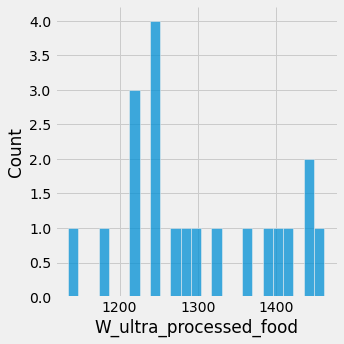

In [12]:
# Check for extreme values
stats = data_all.groupby('date').count()
sns.displot(stats['W_ultra_processed_food'], bins=25) 

**The data is skewed therefore use the median**

In [13]:
#### Aggregate values to get the median per quarter and convert back to dataframe
data = data_all.groupby('date')['W_ultra_processed_food'].median().to_frame()
data

,W_ultra_processed_food
date,
2015-06-30,416.614169
2015-09-30,441.833451
2015-12-31,479.034645
2016-03-31,521.344244
2016-06-30,440.757056
2016-09-30,423.444803
2016-12-31,456.787991
2017-03-31,463.550493
2017-06-30,449.583646


In [14]:
# check for missing values
data.isnull().sum() 

W_ultra_processed_food    0
dtype: int64

In [15]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

# No dups!

0

In [16]:
# check data shape
data.shape

(20, 1)

In [17]:
# check data type
type(data)

pandas.core.frame.DataFrame

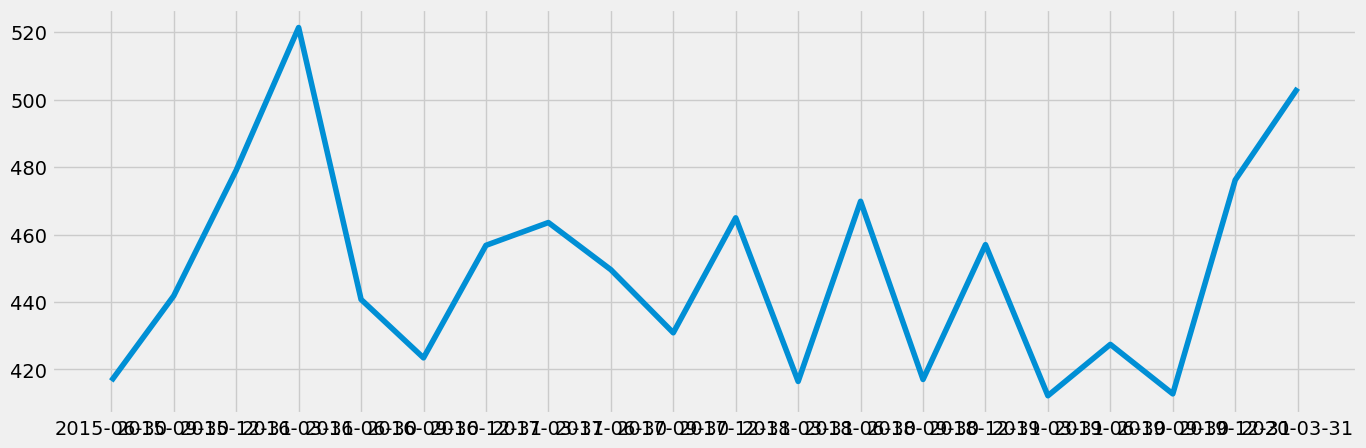

In [18]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

#### '%ultra_processed_food'

In [19]:
# Find the mean and median
data_all.groupby('date')['%ultra_processed_food'].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2015-06-30,1280.0,32.168916,14.346188,0.0,22.049288,31.346960,40.706969,95.844660
2015-09-30,1221.0,32.586253,14.712934,0.0,22.455438,31.784050,41.575092,100.000000
2015-12-31,1246.0,35.247788,15.262153,0.0,24.267335,34.038120,44.857048,96.184561
2016-03-31,1134.0,33.658180,14.999201,0.0,23.855301,32.380163,42.379872,100.000000
2016-06-30,1216.0,32.130126,14.515929,0.0,22.248768,31.232185,40.631473,100.000000
2016-09-30,1248.0,32.474692,14.785421,0.0,22.255119,31.187962,41.452957,88.536155
2016-12-31,1303.0,34.227077,14.628863,0.0,23.898522,33.135914,43.625099,88.413002
2017-03-31,1240.0,32.829570,14.990446,0.0,21.940086,31.518926,41.925746,94.310840
2017-06-30,1271.0,32.862275,14.729246,0.0,22.180336,31.763086,41.935229,100.000000


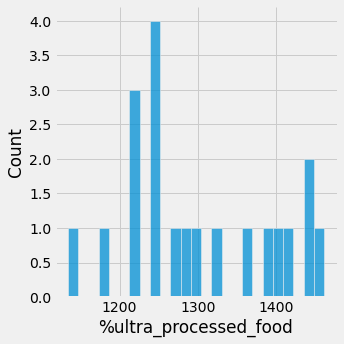

In [20]:
# Check for extreme values
stats_per = data_all.groupby('date').count()
sns.displot(stats_per['%ultra_processed_food'], bins=25) 

**The data is skewed therefore use the median**

In [21]:
#### Aggregate values to get the mean per quarter and convert back to dataframe
data_per = data_all.groupby('date')['%ultra_processed_food'].median().to_frame()
data_per

,%ultra_processed_food
date,
2015-06-30,31.346960
2015-09-30,31.784050
2015-12-31,34.038120
2016-03-31,32.380163
2016-06-30,31.232185
2016-09-30,31.187962
2016-12-31,33.135914
2017-03-31,31.518926
2017-06-30,31.763086


In [22]:
# check for missing values
data_per.isnull().sum() 

%ultra_processed_food    0
dtype: int64

In [23]:
# Check for duplicates

dups = data_per.duplicated()
dups.sum()

# No dups!

0

In [24]:
# check data shape
data_per.shape

(20, 1)

In [25]:
# check data type
type(data_per)

pandas.core.frame.DataFrame

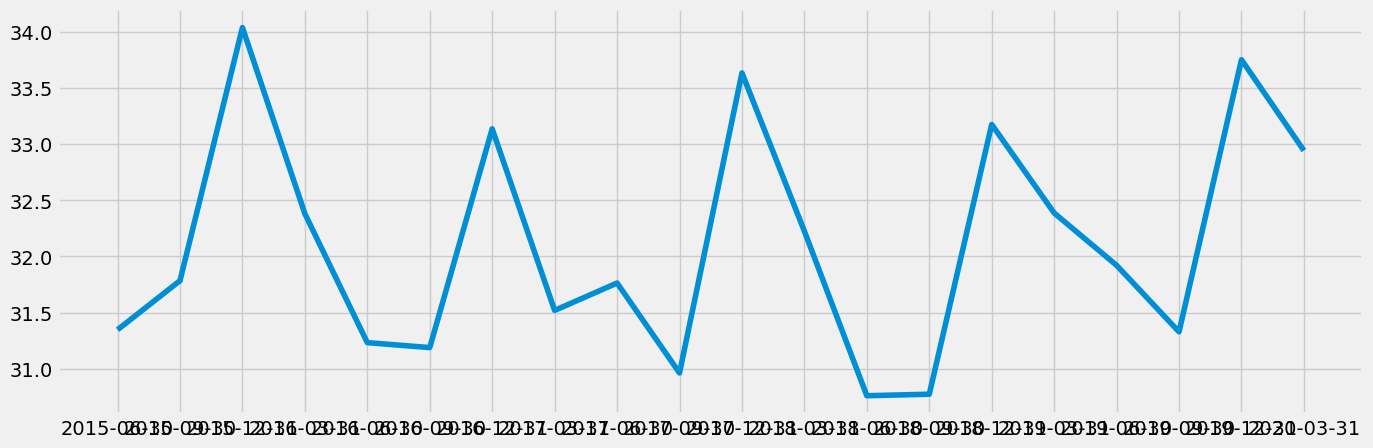

In [26]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data_per)

#### '%ultra_processed_food' - South West

In [27]:
# Create subgroup for the South West region and find the mean and median
grp_SW = data_all.groupby('region').get_group('South West')
data_perSW = grp_SW.groupby('date')['%ultra_processed_food'].describe()
data_perSW

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2015-06-30,120.0,32.605580,13.260401,7.853314,24.292200,32.621855,39.403660,77.084687
2015-09-30,104.0,33.508895,13.288961,5.363689,23.173570,31.990749,42.353277,70.395074
2015-12-31,129.0,35.945406,13.651910,9.828200,25.964866,33.008763,45.608880,78.347057
2016-03-31,108.0,33.152363,14.438557,2.407755,22.842232,32.508629,40.189144,93.388068
2016-06-30,108.0,30.656433,12.772548,4.516977,21.868339,30.289574,37.709195,81.415329
2016-09-30,120.0,33.201952,13.002006,5.841524,24.531781,32.058614,39.769815,74.536719
2016-12-31,136.0,33.010397,13.037016,1.193123,22.116797,33.443892,41.544819,69.582993
2017-03-31,127.0,31.406726,14.864191,0.000000,21.846808,31.139670,38.630184,92.729712
2017-06-30,124.0,32.401812,13.814113,0.000000,22.296741,31.749979,41.453401,79.283640


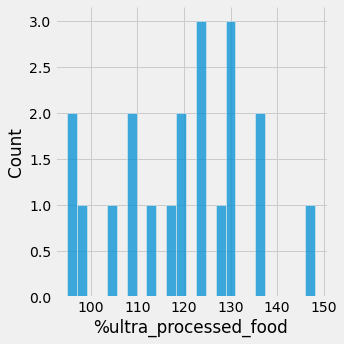

In [28]:
# Check for extreme values
stats_perSW = grp_SW.groupby('date').count()
sns.displot(stats_perSW['%ultra_processed_food'], bins=25) 

**The data is skewed therefore use the median**

In [29]:
#### Aggregate values to get the mean per quarter and convert back to dataframe
data_perSW = grp_SW.groupby('date')['%ultra_processed_food'].median().to_frame()
data_perSW

,%ultra_processed_food
date,
2015-06-30,32.621855
2015-09-30,31.990749
2015-12-31,33.008763
2016-03-31,32.508629
2016-06-30,30.289574
2016-09-30,32.058614
2016-12-31,33.443892
2017-03-31,31.139670
2017-06-30,31.749979


In [30]:
# check for missing values
data_perSW.isnull().sum() 

%ultra_processed_food    0
dtype: int64

In [31]:
# Check for duplicates

dups = data_perSW.duplicated()
dups.sum()

# No dups!

0

In [32]:
# check data shape
data_perSW.shape

(20, 1)

In [33]:
# check data type
type(data_perSW)

pandas.core.frame.DataFrame

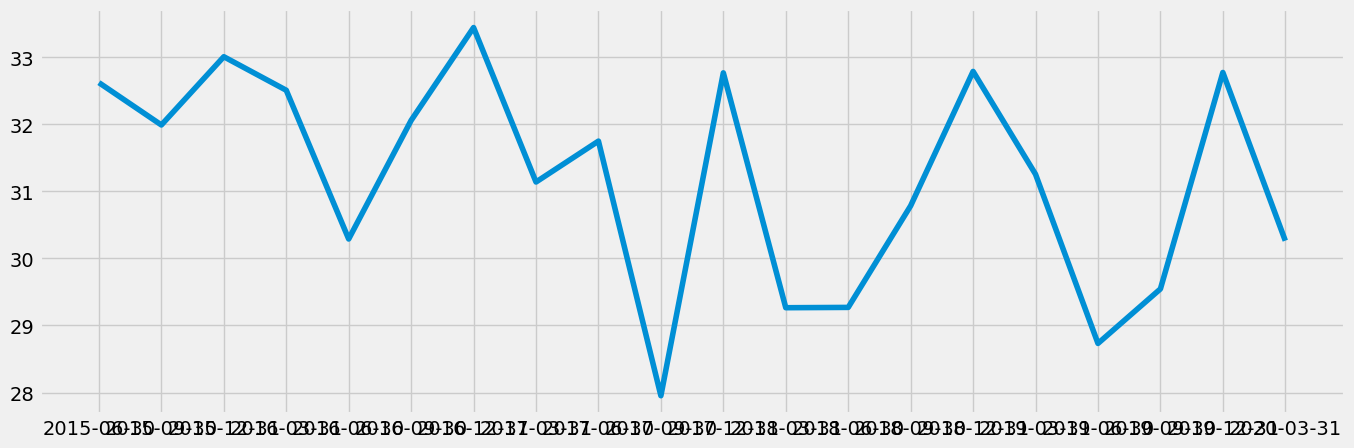

In [34]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data_perSW)

#### '%ultra_processed_food' - North West

In [35]:
# Create subgroup for the North West region and find the mean and median
grp_NW = data_all.groupby('region').get_group('North West')
data_perNW = grp_NW.groupby('date')['%ultra_processed_food'].describe()
data_perNW

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2015-06-30,149.0,33.275102,14.303435,0.000000,24.446086,31.285997,43.927526,76.878613
2015-09-30,122.0,31.571179,13.541831,4.900662,21.265367,31.065916,40.684730,72.959805
2015-12-31,134.0,35.926162,16.356061,0.000000,25.517324,34.661419,44.808858,80.456569
2016-03-31,134.0,34.508892,16.935615,0.000000,23.938895,32.689022,43.793858,100.000000
2016-06-30,139.0,34.832223,16.669168,0.000000,22.538574,33.790545,43.107861,90.585106
2016-09-30,139.0,32.066291,14.766672,8.413645,20.618917,29.057971,42.221632,79.169212
2016-12-31,153.0,38.500142,15.887632,0.000000,27.473118,37.905666,49.823892,86.892147
2017-03-31,137.0,34.965550,15.518571,2.118721,22.689405,32.042254,45.910843,71.813015
2017-06-30,115.0,33.480510,14.063750,4.722460,25.076879,33.969080,41.580514,71.335234


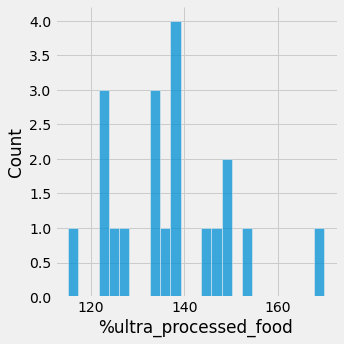

In [36]:
# Check for extreme values
stats_perNW = grp_NW.groupby('date').count()
sns.displot(stats_perNW['%ultra_processed_food'], bins=25) 

**The data is skewed therefore use the median**

In [37]:
#### Aggregate values to get the mean per quarter and convert back to dataframe
data_perNW = grp_NW.groupby('date')['%ultra_processed_food'].median().to_frame()
data_perNW

,%ultra_processed_food
date,
2015-06-30,31.285997
2015-09-30,31.065916
2015-12-31,34.661419
2016-03-31,32.689022
2016-06-30,33.790545
2016-09-30,29.057971
2016-12-31,37.905666
2017-03-31,32.042254
2017-06-30,33.969080


In [38]:
# check for missing values
data_perNW.isnull().sum() 

%ultra_processed_food    0
dtype: int64

In [39]:
# Check for duplicates

dups = data_perNW.duplicated()
dups.sum()

# No dups!

0

In [40]:
# check data shape
data_perNW.shape

(20, 1)

In [41]:
# check data type
type(data_perNW)

pandas.core.frame.DataFrame

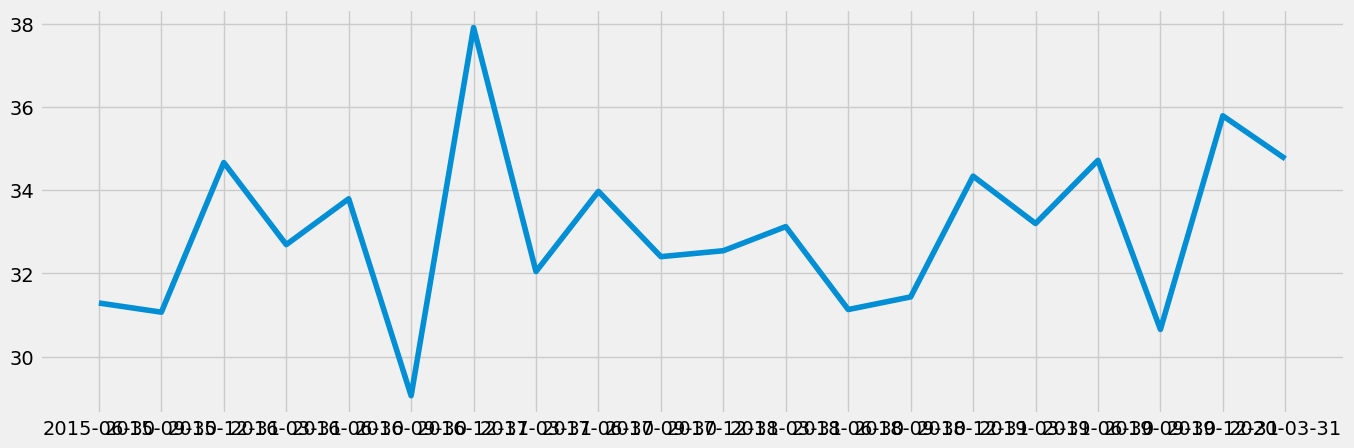

In [42]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data_perNW)

#### '%ultra_processed_food' - North East

In [43]:
# Create subgroup for the Morth East region and find the mean and median
grp_NE = data_all.groupby('region').get_group('North East')
data_perNE = grp_NE.groupby('date')['%ultra_processed_food'].describe()
data_perNE

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2015-06-30,69.0,34.499598,13.968703,6.745040,22.866602,35.254478,42.150515,72.777330
2015-09-30,54.0,35.272926,13.602662,0.000000,25.678769,33.431367,46.624440,69.397688
2015-12-31,53.0,38.738122,18.068555,4.678689,25.974510,37.778969,47.274500,92.857143
2016-03-31,53.0,39.459261,16.017432,12.952814,28.903924,37.488484,49.545931,81.465183
2016-06-30,63.0,33.566077,14.128215,2.963423,23.217416,33.209584,41.813300,76.757441
2016-09-30,51.0,34.389438,14.342751,5.507490,25.499272,31.688860,43.394091,72.907679
2016-12-31,60.0,36.622404,17.353846,3.560699,24.738025,33.405894,51.225005,80.617743
2017-03-31,62.0,33.336305,13.570571,6.084147,23.084364,32.944121,41.987169,65.364827
2017-06-30,45.0,37.037007,17.206135,0.000000,24.867342,35.233220,49.135120,83.389504


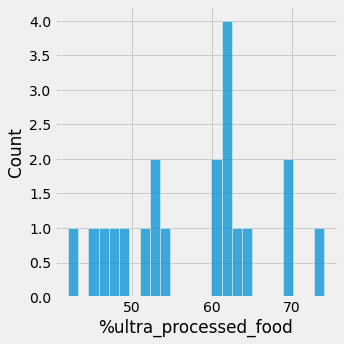

In [44]:
# Check for extreme values
stats_perNE = grp_NE.groupby('date').count()
sns.displot(stats_perNE['%ultra_processed_food'], bins=25) 

**The data is skewed therefore use the median**

In [45]:
#### Aggregate values to get the mean per quarter and convert back to dataframe
data_perNE = grp_NE.groupby('date')['%ultra_processed_food'].median().to_frame()
data_perNE

,%ultra_processed_food
date,
2015-06-30,35.254478
2015-09-30,33.431367
2015-12-31,37.778969
2016-03-31,37.488484
2016-06-30,33.209584
2016-09-30,31.688860
2016-12-31,33.405894
2017-03-31,32.944121
2017-06-30,35.233220


In [46]:
# check for missing values
data_perNE.isnull().sum() 

%ultra_processed_food    0
dtype: int64

In [47]:
# Check for duplicates

dups = data_perNE.duplicated()
dups.sum()

# No dups!

0

In [48]:
# check data shape
data_perNE.shape

(20, 1)

In [49]:
# check data type
type(data_perNE)

pandas.core.frame.DataFrame

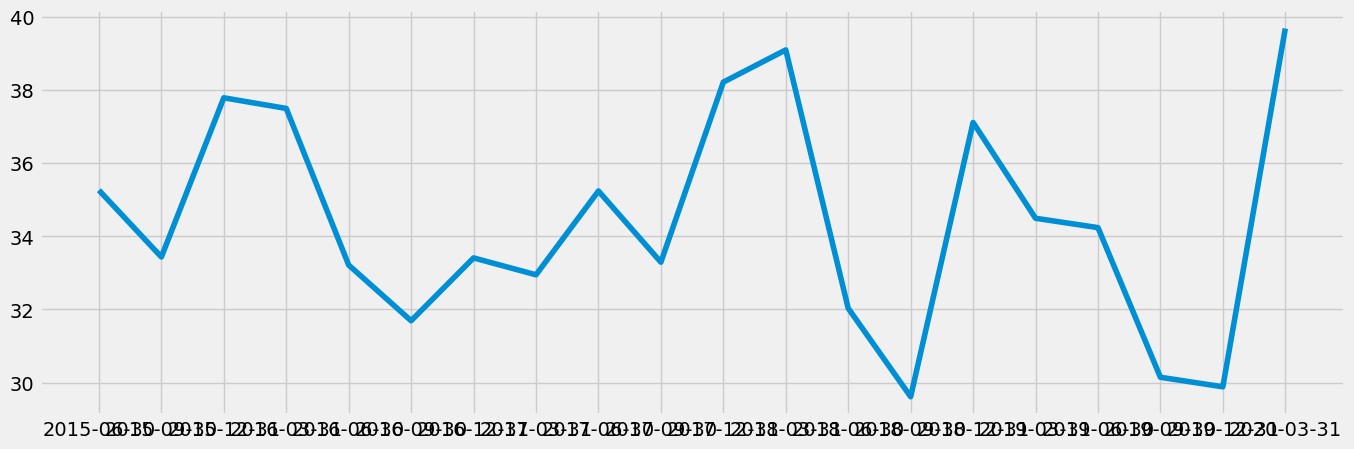

In [50]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data_perNE)

### Subsetting and changing to timeseries data

The data set range was small and covers the period identified for the anlysis so it was kept, but the '%unprocessed_food variable' was grouped to look at trends in the South West, North West and North East. These areas were identified in the geospatial analysis as having the greatest change in obesity or percentage spent on ultra_processed food.

#### 'W-ultra_processed_food'

In [51]:
# Reset index so that the "date" column can be used as a filter and view

data = data.reset_index()
data.head()

,date,W_ultra_processed_food
0,2015-06-30,416.614169
1,2015-09-30,441.833451
2,2015-12-31,479.034645
3,2016-03-31,521.344244
4,2016-06-30,440.757056


In [52]:
# Set the "date" column as the index

from datetime import datetime

data['datetime'] = pd.to_datetime(data['date']) # Create a datetime column from "Date.""
data = data.set_index('datetime') # Set the datetime as the index of the dataframe.
data.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data.sort_values(by = 'datetime', inplace = True)
data.head()

,W_ultra_processed_food
datetime,
2015-06-30,416.614169
2015-09-30,441.833451
2015-12-31,479.034645
2016-03-31,521.344244
2016-06-30,440.757056


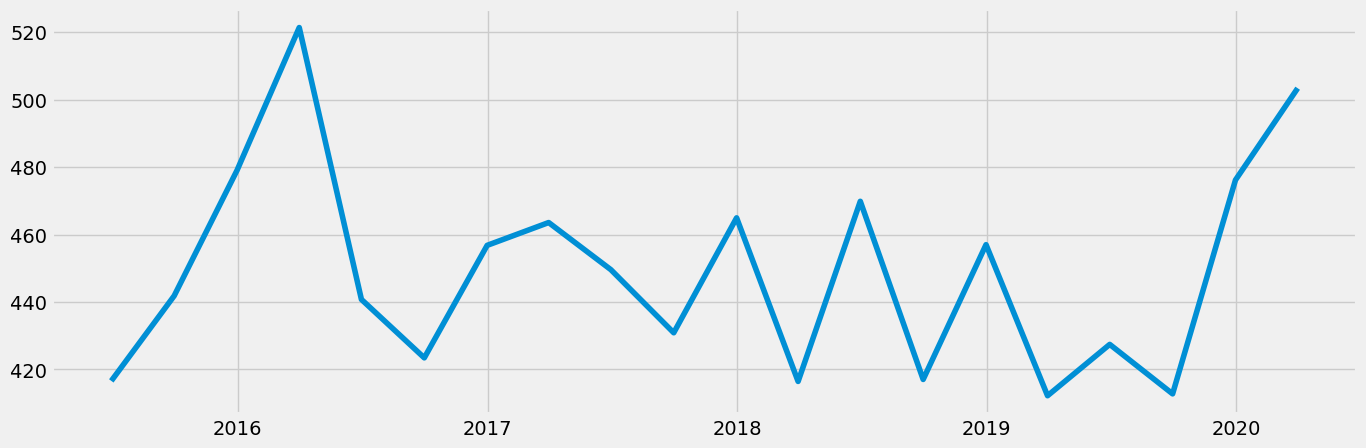

In [53]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

#### %ultra_processed_food'

In [54]:
# Reset index so that the "date" column can be used as a filter and view

data_per = data_per.reset_index()
data_per.head()

,date,%ultra_processed_food
0,2015-06-30,31.346960
1,2015-09-30,31.784050
2,2015-12-31,34.038120
3,2016-03-31,32.380163
4,2016-06-30,31.232185


In [55]:
# Set the "date" column as the index

from datetime import datetime

data_per['datetime'] = pd.to_datetime(data_per['date']) # Create a datetime column from "Date.""
data_per = data_per.set_index('datetime') # Set the datetime as the index of the dataframe.
data_per.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_per.sort_values(by = 'datetime', inplace = True)
data_per.head()

,%ultra_processed_food
datetime,
2015-06-30,31.346960
2015-09-30,31.784050
2015-12-31,34.038120
2016-03-31,32.380163
2016-06-30,31.232185


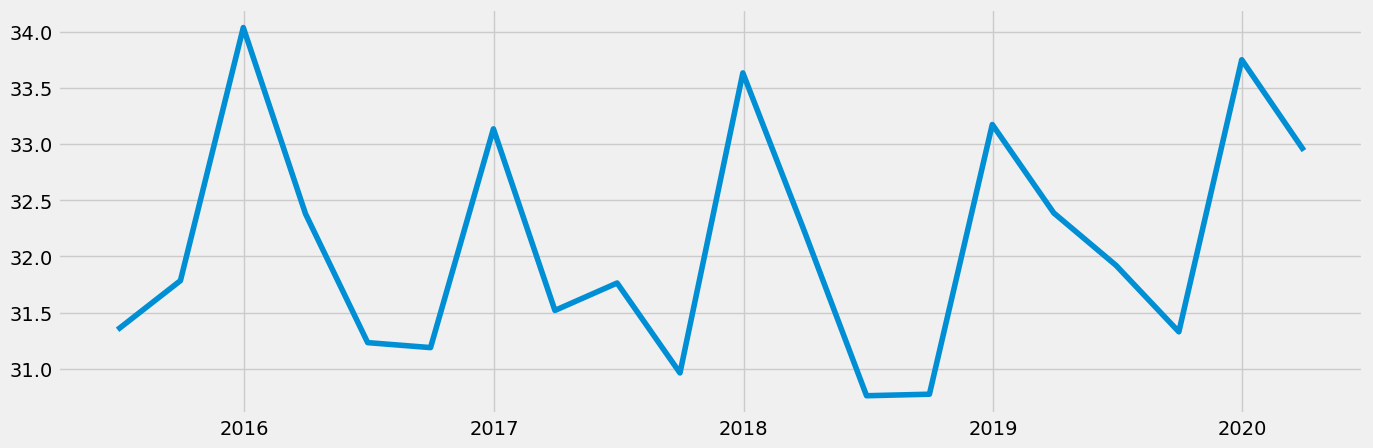

In [56]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_per)

#### %ultra_processed_food_SW'

In [57]:
# Reset index so that the "date" column can be used as a filter and view

data_perSW = data_perSW.reset_index()
data_perSW.head()

,date,%ultra_processed_food
0,2015-06-30,32.621855
1,2015-09-30,31.990749
2,2015-12-31,33.008763
3,2016-03-31,32.508629
4,2016-06-30,30.289574


In [58]:
# Set the "date" column as the index

from datetime import datetime

data_perSW['datetime'] = pd.to_datetime(data_perSW['date']) # Create a datetime column from "Date.""
data_perSW = data_perSW.set_index('datetime') # Set the datetime as the index of the dataframe.
data_perSW.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_perSW.sort_values(by = 'datetime', inplace = True)
data_perSW.head()

,%ultra_processed_food
datetime,
2015-06-30,32.621855
2015-09-30,31.990749
2015-12-31,33.008763
2016-03-31,32.508629
2016-06-30,30.289574


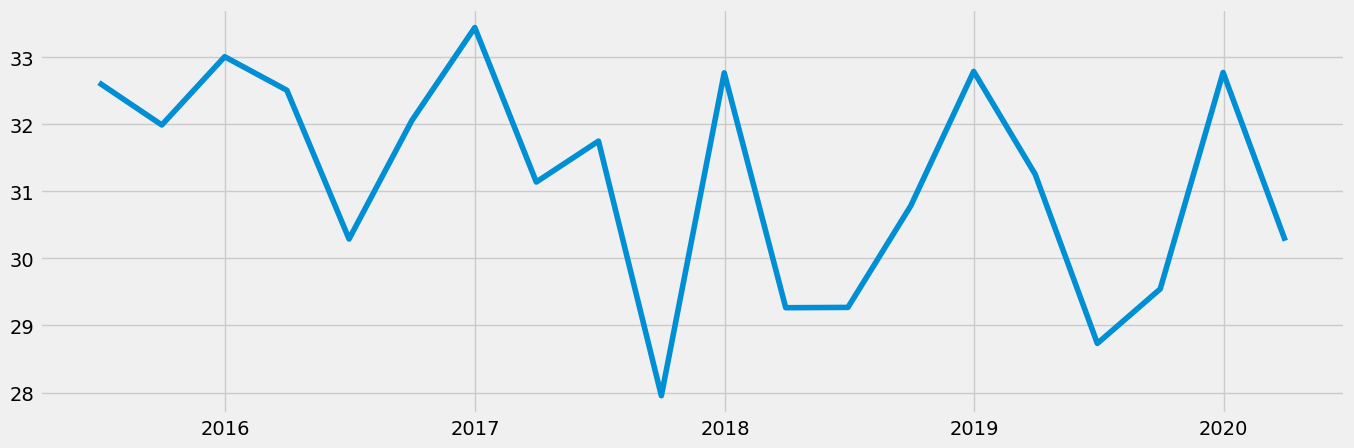

In [59]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_perSW)

#### %ultra_processed_food_NW'

In [60]:
# Reset index so that the "date" column can be used as a filter and view

data_perNW = data_perNW.reset_index()
data_perNW.head()

,date,%ultra_processed_food
0,2015-06-30,31.285997
1,2015-09-30,31.065916
2,2015-12-31,34.661419
3,2016-03-31,32.689022
4,2016-06-30,33.790545


In [61]:
# Set the "date" column as the index

from datetime import datetime

data_perNW['datetime'] = pd.to_datetime(data_perNW['date']) # Create a datetime column from "Date.""
data_perNW = data_perNW.set_index('datetime') # Set the datetime as the index of the dataframe.
data_perNW.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_perNW.sort_values(by = 'datetime', inplace = True)
data_perNW.head()

,%ultra_processed_food
datetime,
2015-06-30,31.285997
2015-09-30,31.065916
2015-12-31,34.661419
2016-03-31,32.689022
2016-06-30,33.790545


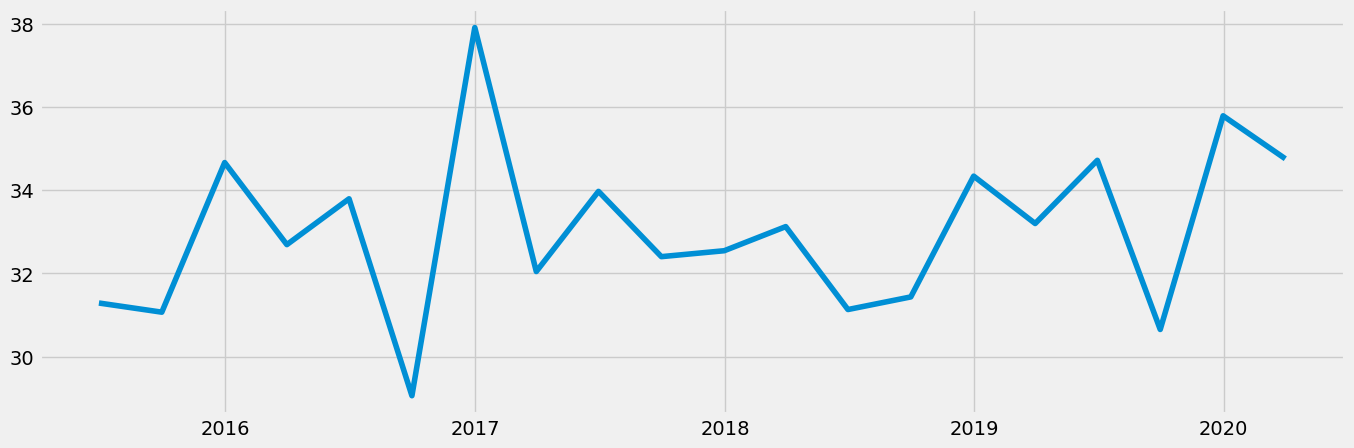

In [62]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_perNW)

#### %ultra_processed_food_NE'

In [63]:
# Reset index so that the "date" column can be used as a filter and view

data_perNE = data_perNE.reset_index()
data_perNE.head()

,date,%ultra_processed_food
0,2015-06-30,35.254478
1,2015-09-30,33.431367
2,2015-12-31,37.778969
3,2016-03-31,37.488484
4,2016-06-30,33.209584


In [64]:
# Set the "date" column as the index

from datetime import datetime

data_perNE['datetime'] = pd.to_datetime(data_perNE['date']) # Create a datetime column from "Date.""
data_perNE = data_perNE.set_index('datetime') # Set the datetime as the index of the dataframe.
data_perNE.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
data_perNE.sort_values(by = 'datetime', inplace = True)
data_perNE.head()

,%ultra_processed_food
datetime,
2015-06-30,35.254478
2015-09-30,33.431367
2015-12-31,37.778969
2016-03-31,37.488484
2016-06-30,33.209584


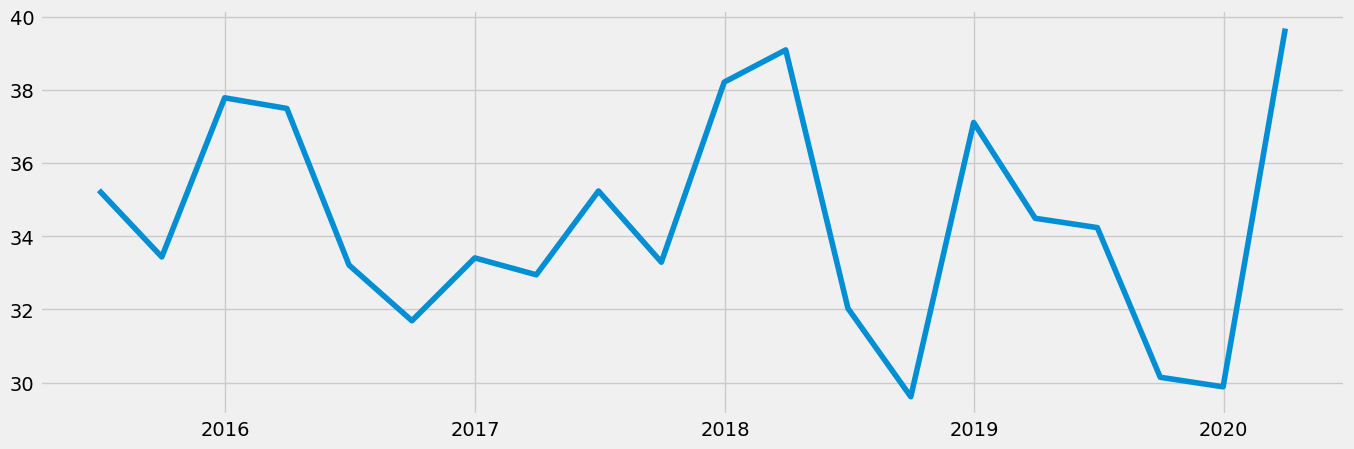

In [65]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_perNE)

## 03. Time-Series Analysis: Decomposition

In [66]:
# Change the working directory and show directory path
os.chdir(r'/Users/elsaekevall/Jupyter_Notebook/Career_Foundry/09_2022_LCF_Analysis/04_Analysis')
os.getcwd()

'/Users/elsaekevall/Jupyter_Notebook/Career_Foundry/09_2022_LCF_Analysis/04_Analysis'

#### 'W_ultra_processed_food'

In [67]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model = 'multiplicative')

In [68]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

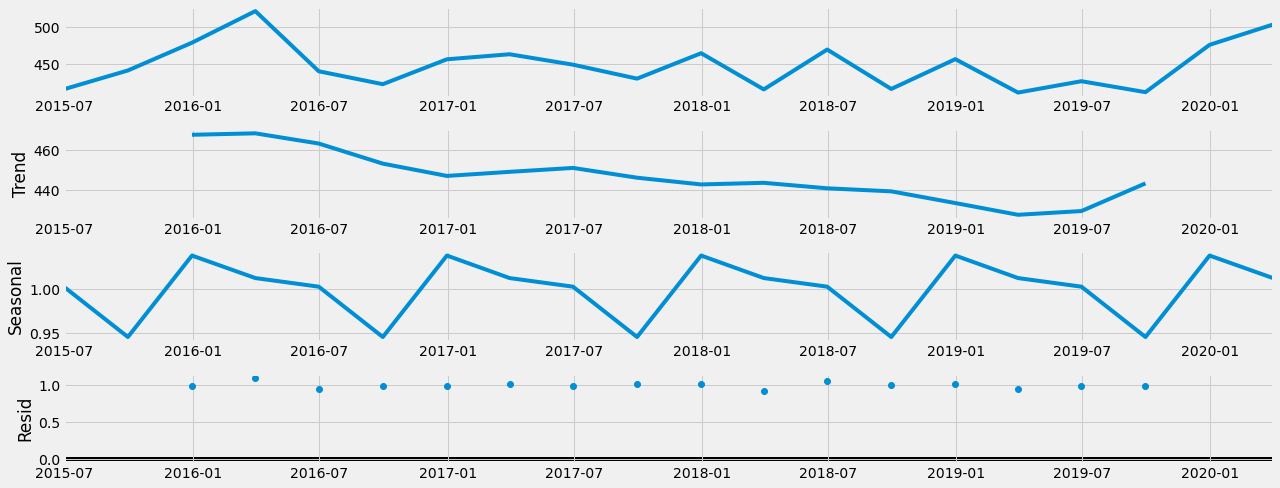

In [69]:
# Plot the separate components

decomposition.plot()

plt.savefig('TS_ultrafood_.png',bbox_inches='tight')

**Overall there is a linear trend, which flattens out in the first half of 2017 and then drops again until the end of Q3 in 2019 when it starts to rise. The residual noise level is consistently around 1, so may have an impact on the trend. At the end of 2019 the UK inflation rate rose rom 0.85% to 2.59%. <br>
The data has seasonality with the amount spent on ultra-processed food rising in the last quarter and peaking around Christmas time. The amount then gradually drops until the end of the second quarter. Between Q2 and Q3 there is a steeper drop - perhaps due more fresh produce being eaten in the summer months and then it rises steeply in Q4.**

#### '%ultra_processed_food'

In [70]:
# Decompose the time series using an additive model - no obvious linear trend

decomposition_per = sm.tsa.seasonal_decompose(data_per, model = 'multiplicative')

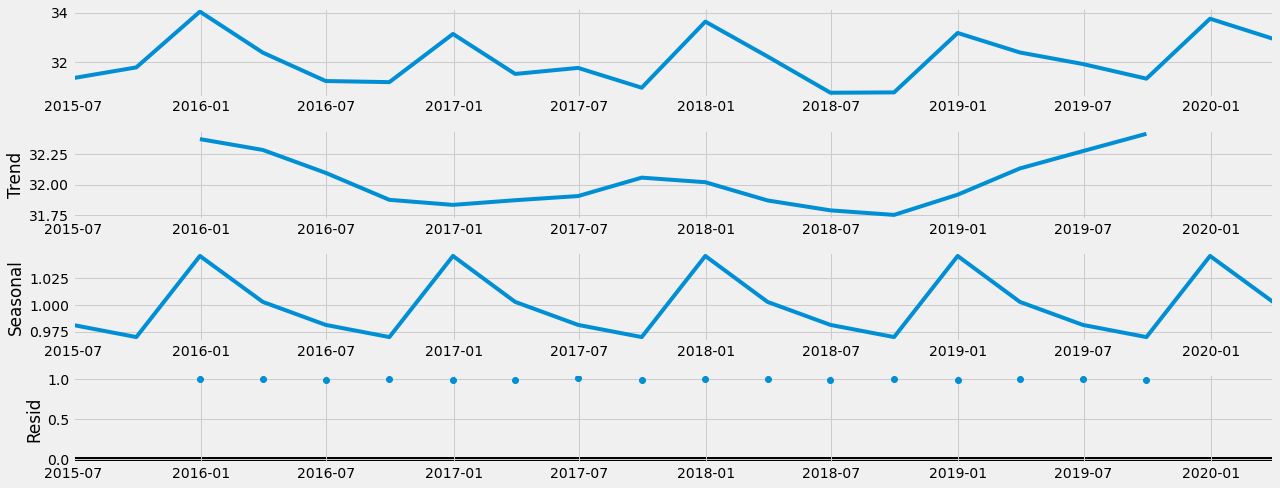

In [71]:
# Plot the separate components

decomposition_per.plot()

plt.savefig('TS_perultrafood_.png',bbox_inches='tight')

**The trend changes with time falling linearly in 2016 until the last quarter when it flattend before rising slightly in the last quarter of 2017. It drops in the first three quarters of 2018 and then rises more steeply. The residual noise level is consistently around 1, so may have an impact on the trend and the range is within 0.5%. <br>
The data has seasonality with the amount spent on ultra-processed food rising in the last quarter of the year and peaking around Christmas time. The amount then gradually drops until the end of the second quarter. Possibly due more fresh produce being eaten in the summer months and then it rises steeply in Q4.**

#### '%ultra_processed_food' - South West

In [72]:
# Decompose the time series using an additive model - no obvious linear trend

decomposition_perSW = sm.tsa.seasonal_decompose(data_perSW, model = 'multiplicative')

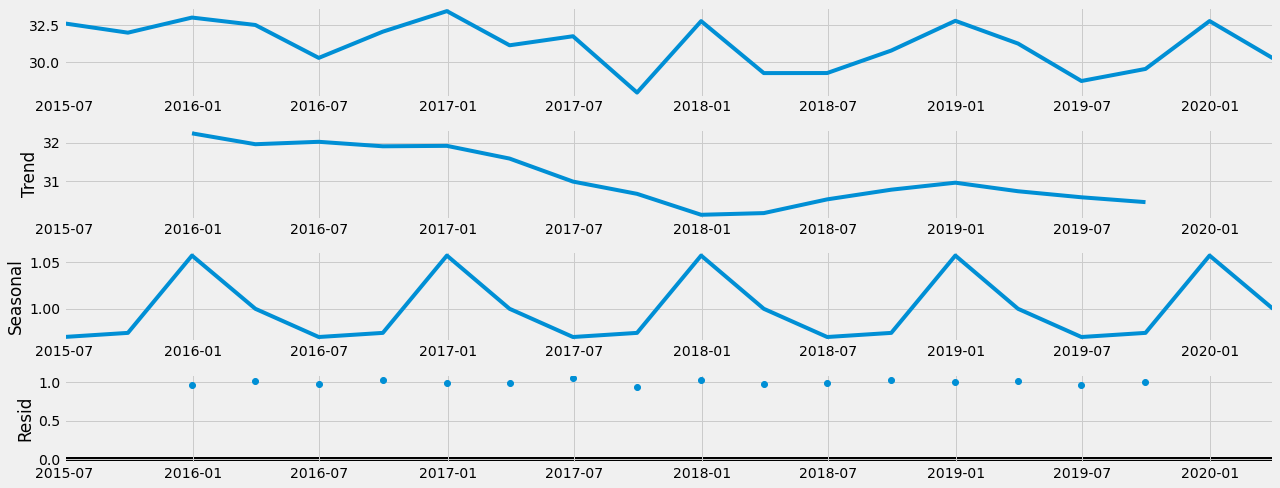

In [73]:
# Plot the separate components

decomposition_perSW.plot()
plt.show()

#### '%ultra_processed_food' - North West

In [74]:
# Decompose the time series using an additive model - no obvious linear trend

decomposition_perNW = sm.tsa.seasonal_decompose(data_perNW, model = 'multiplicative')

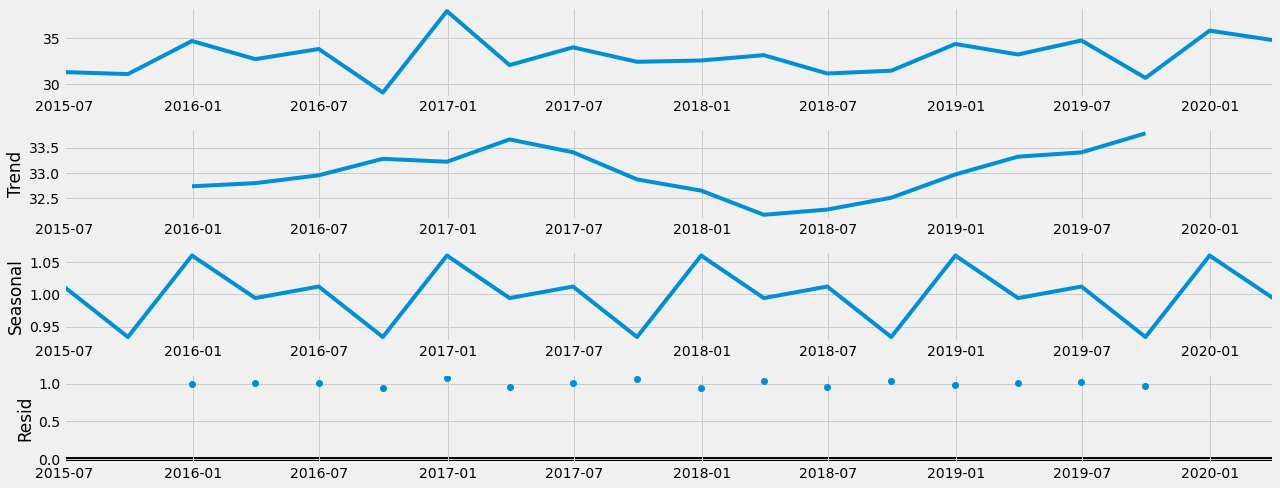

In [75]:
# Plot the separate components

decomposition_perNW.plot()
plt.show()

#### '%ultra_processed_food' - North East

In [76]:
# Decompose the time series using an additive model - no obvious linear trend

decomposition_perNE = sm.tsa.seasonal_decompose(data_perNE, model = 'multiplicative')

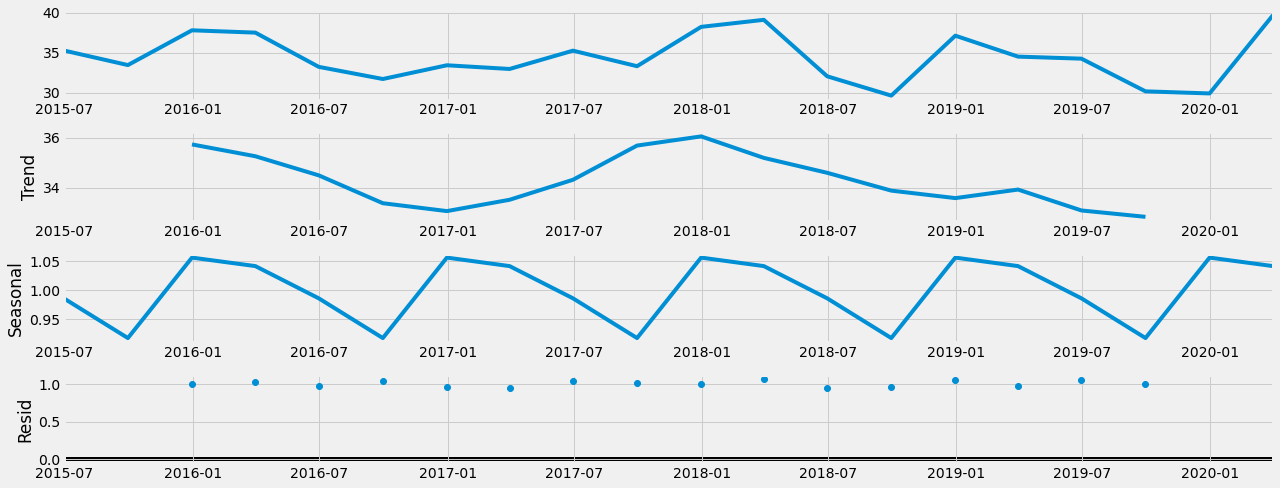

In [77]:
# Plot the separate components

decomposition_perNE.plot()
plt.show()

## 04. Testing for Stationarity

#### 'W_ultra_processed_food'

In [78]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data['W_ultra_processed_food'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.467668
p-value                         0.898173
Number of Lags Used             8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


**The test statistic is -0.47 and the p-value 90 whcih is above 0.05, therefore the test is not significant. At 5% the critical value is -3.19, which is much smaller than the test statistic. Therefore the null hypothesisi can't be refjected and the data is non-stationary.**

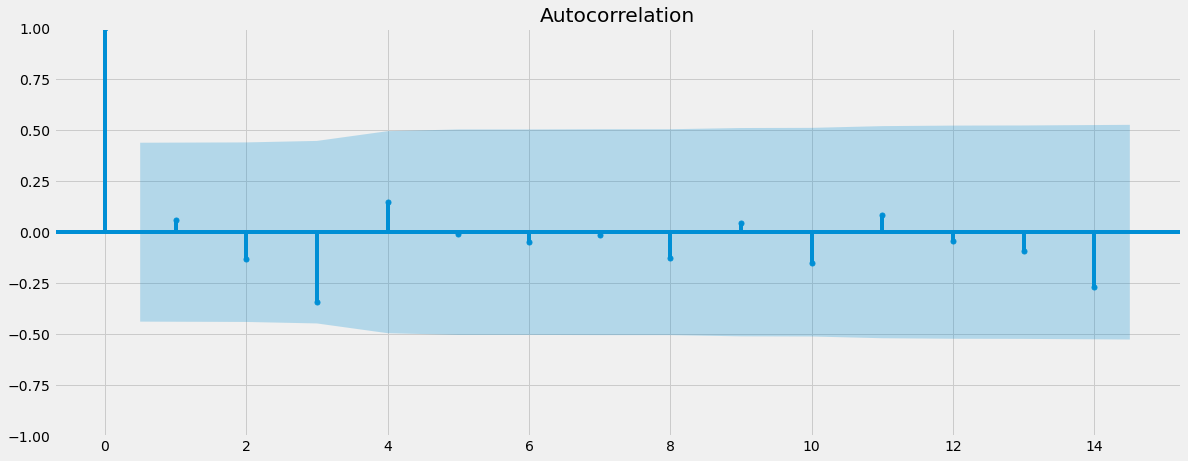

In [79]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data)
plt.show()

**There is no need to stationarise the data - all points, except the first which is always 1, fall within the confidence interval**

#### '%ultra_processed_food'

In [80]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_per['%ultra_processed_food'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.965763
p-value                         0.765546
Number of Lags Used             8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


**The test statistic is -0.97 and the p-value 0.77 whcih is above 0.05, therefore the test is not significant. At 5% the critical value is -3.19, which is much smaller than the test statistic. Therefore the null hypothesisi can't be rejected and the data is non-stationary.**

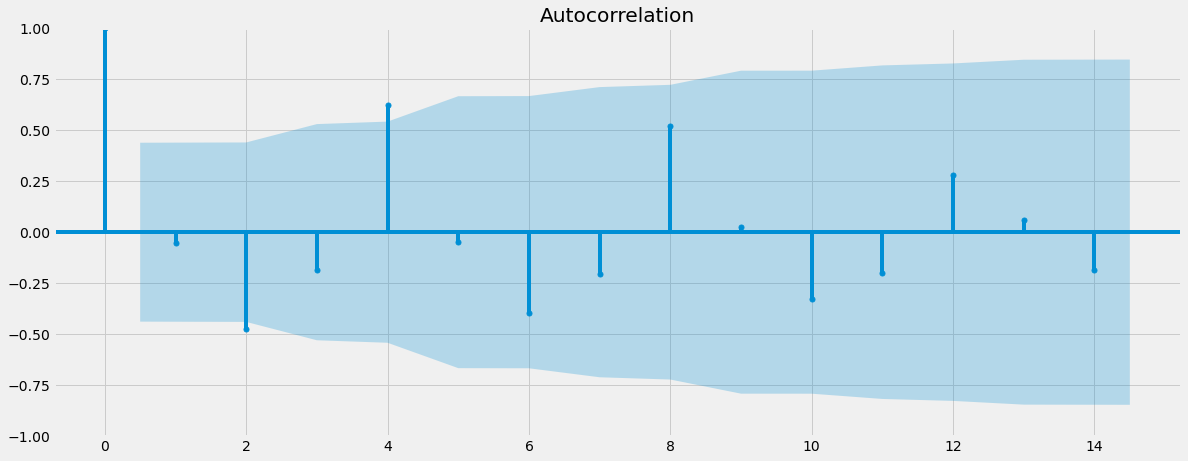

In [81]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_per)
plt.show()

**There is no need to stationarise the data - only two points fall outside the confidence interval**

#### '%ultra_processed_food' - South West

In [82]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_perSW['%ultra_processed_food'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.431259
p-value                         0.567202
Number of Lags Used             7.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


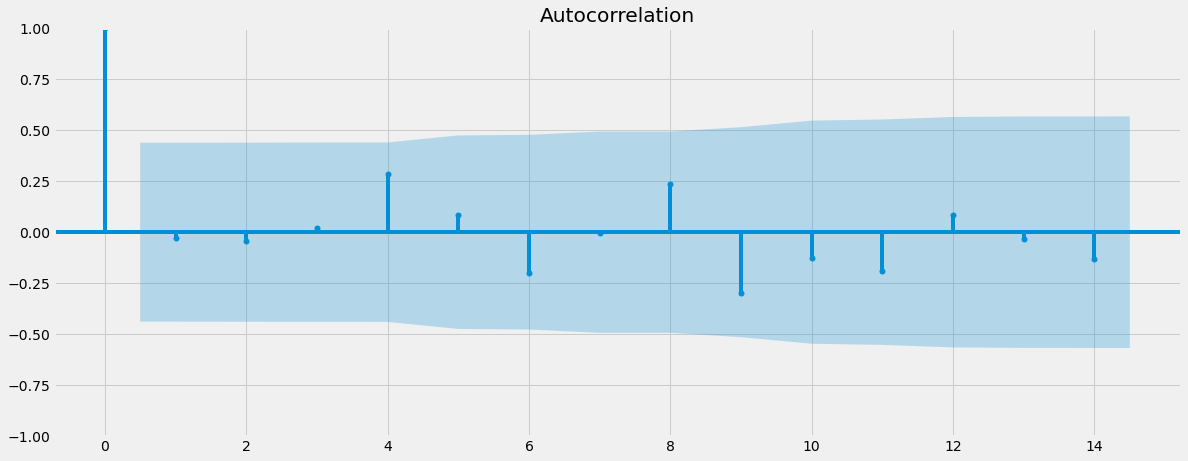

In [83]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_perSW)
plt.show()

**There is no need to stationarise the data -no points fall outside the confidence interval**

#### '%ultra_processed_food' - North West

In [84]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_perNW['%ultra_processed_food'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.413964
p-value                         0.575564
Number of Lags Used             8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


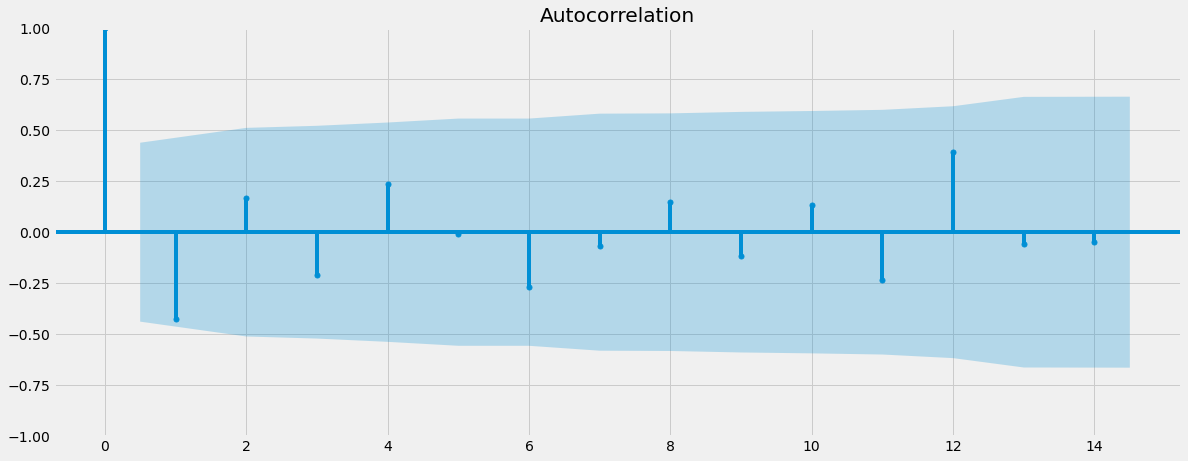

In [85]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_perNW)
plt.show()

**There is no need to stationarise the data -no points fall outside the confidence interval**

#### '%ultra_processed_food' - North East

In [86]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_perNE['%ultra_processed_food'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.917676
p-value                         0.001909
Number of Lags Used             8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


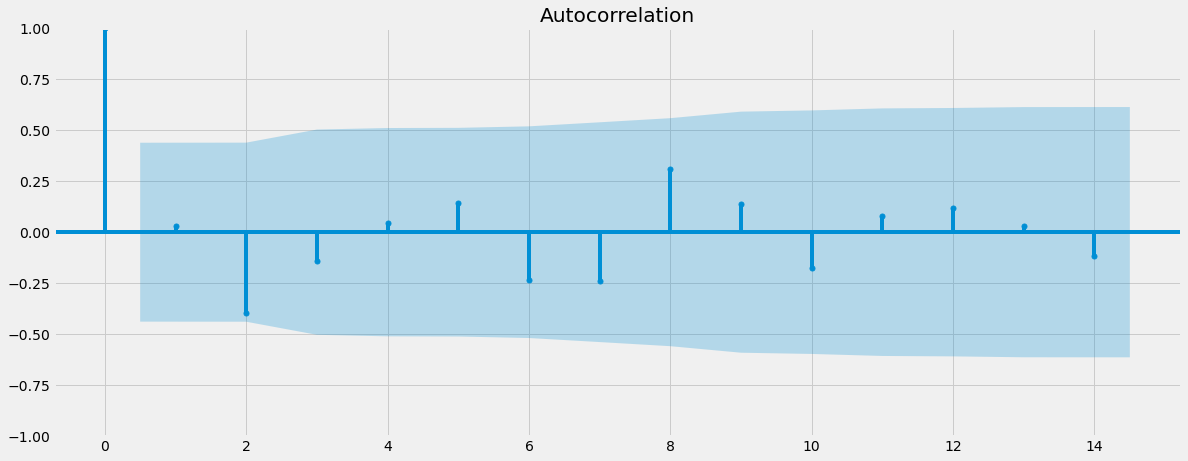

In [87]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_perNE)
plt.show()

**There is no need to stationarise the data -no points fall outside the confidence interval**

## 05. Applying the ARIMA Model

### Defining the Parameters

No differencing was applied therefore d = 0

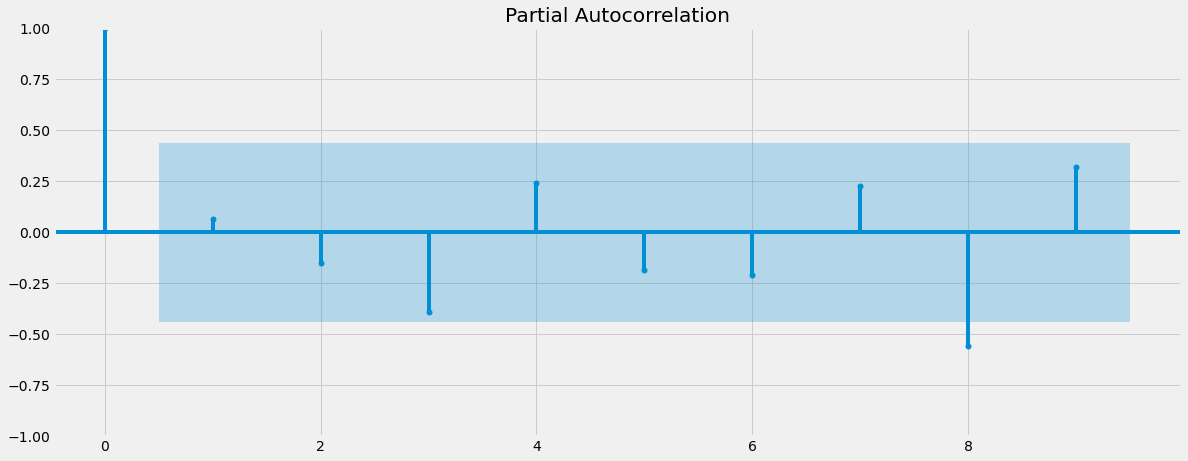

<Figure size 4500x4500 with 0 Axes>

In [88]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(data, lags = 9)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

Only one highly positive bar indicating significant correlations. 
* Pick 1 AR terms to compensate for the highest of the partial autocorrelations. Try p = 1.
* From autocorrelation above no bars were outside the confidence interval. Try q = 1
* No differencing was applied. d = 0

### Splitting the Data

#### 'W_ultra_processed_food'

Split the data at the end of Q1 in 2019, just before the trend rises in the graph

In [89]:
data.reset_index()

,datetime,W_ultra_processed_food
0,2015-06-30,416.614169
1,2015-09-30,441.833451
2,2015-12-31,479.034645
3,2016-03-31,521.344244
4,2016-06-30,440.757056
5,2016-09-30,423.444803
6,2016-12-31,456.787991
7,2017-03-31,463.550493
8,2017-06-30,449.583646
9,2017-09-30,430.877327


In [90]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [91]:
data.loc['2019-03-31']

W_ultra_processed_food    412.217303
Name: 2019-03-31 00:00:00, dtype: float64

In [92]:
# Split the data

train = data['W_ultra_processed_food'][:16]
test = data['W_ultra_processed_food'][15:]

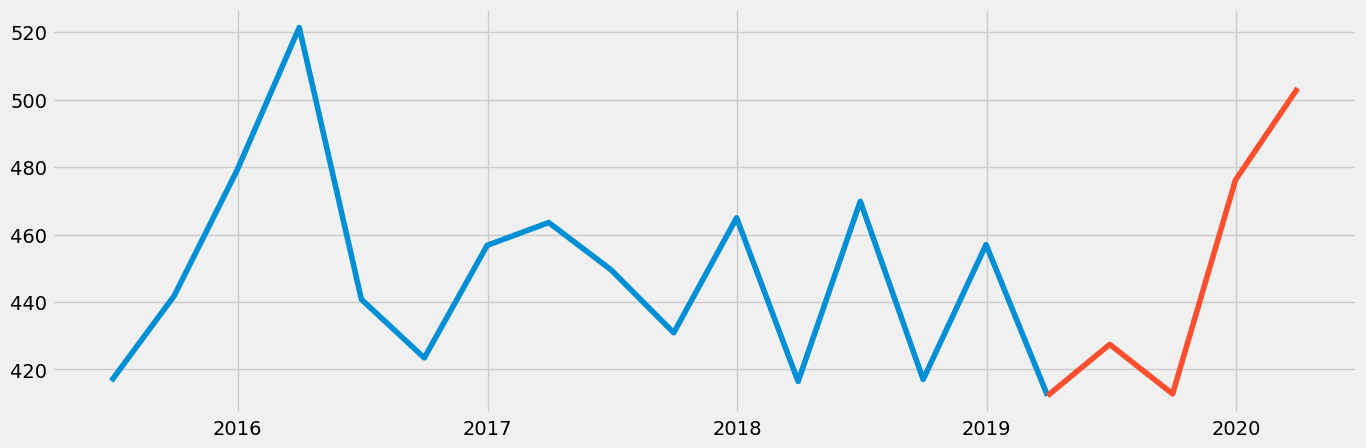

In [93]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [94]:
test.shape

(5,)

### Running and Fitting the Model

In [95]:
from statsmodels.tsa.api import ARIMA # Import the model you need

In [96]:
type(test.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [97]:
model = ARIMA(train, order = (1, 0, 1))  # order = (p, d, q)
fitted = model.fit()  
print(fitted.summary()) # Check model summary

                                 SARIMAX Results                                  
Dep. Variable:     W_ultra_processed_food   No. Observations:                   16
Model:                     ARIMA(1, 0, 1)   Log Likelihood                 -75.473
Date:                    Fri, 28 Oct 2022   AIC                            158.946
Time:                            18:06:37   BIC                            162.037
Sample:                        06-30-2015   HQIC                           159.105
                             - 03-31-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        448.8317      6.157     72.903      0.000     436.765     460.898
ar.L1          0.7080      0.881      0.803      0.422      -1.019       2.435
ma.L1         -0.998

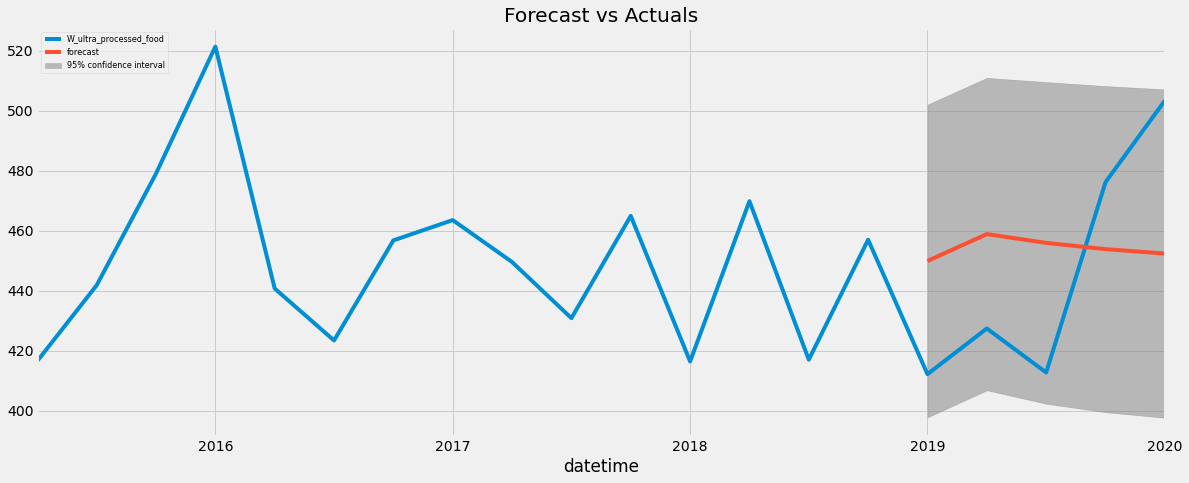

In [98]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
ax = data.plot(ax=ax)
fig = plot_predict(fitted, start = '2019-03-31', end = '2020-03-31', ax=ax)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.show()

#### Rerun ARIMA changing order to 1, 0, 2

In [99]:
model = ARIMA(train, order = (1, 0, 2))  # order = (p, d, q)
fitted = model.fit()  
print(fitted.summary()) # Check model summary

                                 SARIMAX Results                                  
Dep. Variable:     W_ultra_processed_food   No. Observations:                   16
Model:                     ARIMA(1, 0, 2)   Log Likelihood                 -74.331
Date:                    Fri, 28 Oct 2022   AIC                            158.663
Time:                            18:06:37   BIC                            162.525
Sample:                        06-30-2015   HQIC                           158.860
                             - 03-31-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        448.5304     12.872     34.846      0.000     423.302     473.759
ar.L1         -0.8598      0.345     -2.490      0.013      -1.537      -0.183
ma.L1          1.523

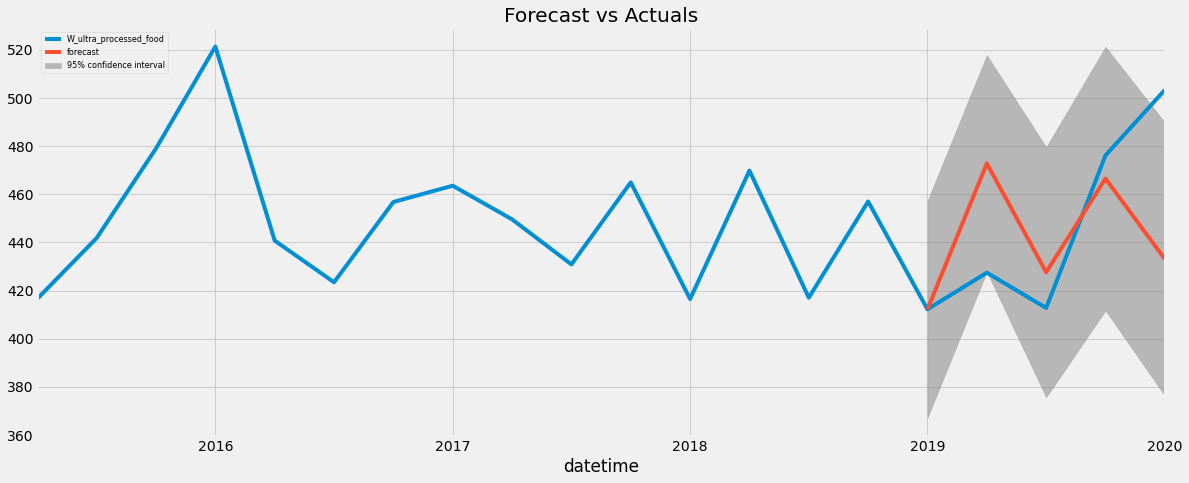

In [100]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
ax = data.plot(ax=ax)
fig = plot_predict(fitted, start = '2019-03-31', end = '2020-03-31', ax=ax)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.show()

### Another method to get the graph

In [101]:
y = train
arma_mod = ARIMA(y, order=(2, 0, 2), trend = 'c') # default trend for models w/o integration; t is linear and ct is constant term and linear
arma_res = arma_mod.fit()

print(arma_res.summary())

                                 SARIMAX Results                                  
Dep. Variable:     W_ultra_processed_food   No. Observations:                   16
Model:                     ARIMA(2, 0, 2)   Log Likelihood                 -73.648
Date:                    Fri, 28 Oct 2022   AIC                            159.296
Time:                            18:06:38   BIC                            163.931
Sample:                        06-30-2015   HQIC                           159.533
                             - 03-31-2019                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        448.3105     10.029     44.701      0.000     428.654     467.967
ar.L1         -1.1503      0.608     -1.892      0.059      -2.342       0.041
ar.L2         -0.319

In [102]:
data.tail()

,W_ultra_processed_food
datetime,
2019-03-31,412.217303
2019-06-30,427.432174
2019-09-30,412.772730
2019-12-31,476.154071
2020-03-31,503.362290


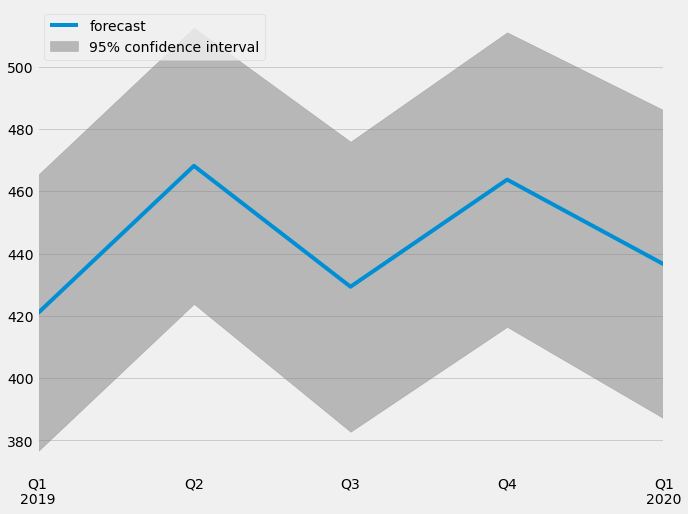

In [103]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arma_res, start="2019-03-31", end="2020-03-31", ax=ax)
legend = ax.legend(loc="upper left")